# Coursera IBM Data Science Capstone Project - Chris Robinson
# Neighborhood Crime Trend Analysis using FourSquare Data

## Import initial set of needed Python packages

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from unicodedata import normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

# Introduction and Problem Description

# Load and Clean Washington DC Neighborhood and Crime Data

In [280]:
#Load Washington DC neighborhood labels and location data
df_DCneigh_coords = pd.read_csv('WashDCNeighborhood_Labels.csv')
df_DCneigh_coords.head()

,Neighborhood,Latitude,Longitude
0,Fort Stanton,38.855658,-76.980348
1,Congress Heights,38.841077,-76.997950
2,Washington Highlands,38.830237,-76.995636
3,Bellevue,38.826952,-77.009271
4,Knox Hill/Buena Vista,38.853688,-76.967660


In [279]:
#Load Washington DC crime data for last two years
df_DCcrimes = pd.read_csv('dc-crimes-search-results_cleaned.csv')
df_DCcrimes.head()

,Neighborhood,OffenseType,OffenseText,Shift,District,Ward,Year,OffenseKey,VotingPrecinct,Date,Location,Latitude,Longitude
0,cluster 17,property,theft/other,evening,4.0,4,2019,property|theft/other,precinct 60,2019-06-03T17:12:18.000,"38.961978891670213,-77.027959395242561",38.961971,-77.027957
1,cluster 8,property,theft/other,day,1.0,6,2019,property|theft/other,precinct 1,2019-06-08T08:05:00.000,"38.902526359929666,-77.015681184476662",38.902519,-77.015679
2,cluster 22,property,theft/other,day,5.0,5,2019,property|theft/other,precinct 72,2019-06-08T10:13:43.000,"38.922219443509491,-76.993152403339593",38.922212,-76.993150
3,cluster 6,property,theft/other,day,2.0,2,2019,property|theft/other,precinct 17,2019-06-08T10:30:50.000,"38.901935207057228,-77.039452838989632",38.901927,-77.039451
4,cluster 5,property,theft f/auto,day,2.0,2,2019,property|theft f/auto,precinct 4,2019-06-07T21:30:31.000,"38.903739943954207,-77.054268346692766",38.903732,-77.054266


In [278]:
#Create a new dataframe to extract just the columns needed --> incident locations, data/time, and offense type.
df_DCcrimes_1 = df_DCcrimes[['Date','OffenseType','Latitude','Longitude']]
df_DCcrimes_1.head()
df_DCcrimes_1.shape

(62016, 4)

In [ ]:
#Convert date-time strings in Date column to date-time objects
df_DCcrimes_1['Date']=pd.to_datetime(df_DCcrimes_1['Date'])
df_DCcrimes_1.head()
#Extract only crimes that happened in 2019
start_date = '2019-01-01 00:00:01'
end_date = '2019-12-31 23:59:59'
df_DCcrimes_2019 = df_DCcrimes_1.loc[(df_DCcrimes_1['Date'] >= start_date) & (df_DCcrimes_1['Date'] <= end_date)].reset_index(drop=True)
print(df_DCcrimes_2019.shape)
df_DCcrimes_2019.head()
df_DCcrimes_2019.tail()

In [277]:
df_DCcrimes_2019.head()

,Date,OffenseType,Latitude,Longitude
0,2019-06-03 17:12:18,property,38.961971,-77.027957
1,2019-06-08 08:05:00,property,38.902519,-77.015679
2,2019-06-08 10:13:43,property,38.922212,-76.993150
3,2019-06-08 10:30:50,property,38.901927,-77.039451
4,2019-06-07 21:30:31,property,38.903732,-77.054266


## Loop through DC neighborhoods and count the number of local crime incidents in 2019. Add columns to the dataframe to capture the results.

In [ ]:
#Loop through each DC neighborhood and count the number of crime incidents in 2019 within a specified radius 
df_DCneigh = df_DCneigh_coords
from geopy import distance
radius = 500
TotalCrimes = []
ViolentCrimes = []
PropertyCrimes = []
for lat,long in zip(df_DCneigh['Latitude'],df_DCneigh['Longitude']):
    crime_count = 0
    violent_count = 0
    property_count = 0 
    neigh_pt = (lat, long)
    for j, (crime_lat, crime_long) in enumerate(zip(df_DCcrimes_2019['Latitude'], df_DCcrimes_2019['Longitude'])):
            crime_pt = (crime_lat, crime_long)
            crime_dist = distance.distance(neigh_pt, crime_pt).meters
            if crime_dist <= radius:
                crime_count = crime_count + 1
                if df_DCcrimes_2019['OffenseType'][j] == 'violent':
                    violent_count = violent_count + 1
                else: 
                    property_count = property_count + 1 
    TotalCrimes.append(crime_count) 
    ViolentCrimes.append(violent_count) 
    PropertyCrimes.append(property_count)
df_DCneigh['TotalCrimes'] = TotalCrimes
df_DCneigh['ViolentCrimes'] = ViolentCrimes
df_DCneigh['PropertyCrimes'] = PropertyCrimes
df_DCneigh.head()

In [276]:
df_DCneigh.shape

(132, 6)

In [281]:
df_DCneigh.head()

,Neighborhood,Latitude,Longitude,TotalCrimes,ViolentCrimes,PropertyCrimes
0,Fort Stanton,38.855658,-76.980348,47,17,30
1,Congress Heights,38.841077,-76.997950,147,50,97
2,Washington Highlands,38.830237,-76.995636,212,53,159
3,Bellevue,38.826952,-77.009271,151,45,106
4,Knox Hill/Buena Vista,38.853688,-76.967660,220,58,162


# Save dataframe with tabulated crime totals to external files

In [282]:
df_DCneigh.to_pickle('DCneigh_crime_totals')

In [283]:
df_DCneigh.to_csv('DCneigh_crime_totals_2019.csv')

# Visualize neighboorhoods on a map

In [284]:
# Use Geopy to get the location of Washington DC"
address = 'Washington, District of Columbia'

geolocator = Nominatim(user_agent="WashingtonDCexplore")
location = geolocator.geocode(address)
DClatitude = location.latitude
DClongitude = location.longitude
print('The geograpical coordinate of Washington, DC are {}, {}.'.format(DClatitude, DClongitude))

The geograpical coordinate of Washington, DC are 38.90651435, -77.03737669188929.


In [285]:
# create map of New York using latitude and longitude values
map_DC = folium.Map(location=[DClatitude, DClongitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df_DCneigh['Latitude'], df_DCneigh['Longitude'], df_DCneigh['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_DC)  
    
map_DC

# Get FourSquare data

In [286]:
CLIENT_ID = 'XGDUVKQRUPQLETE4NXNCEVS1AHQ4HGFFBEUOWQWVL2DL1XE4' # my Foursquare ID
CLIENT_SECRET = 'L0LK1XK24LNOHNJOWDSUMQ0CDBEHX2XGYUKYSBIZUBOXHWUA' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XGDUVKQRUPQLETE4NXNCEVS1AHQ4HGFFBEUOWQWVL2DL1XE4
CLIENT_SECRET:L0LK1XK24LNOHNJOWDSUMQ0CDBEHX2XGYUKYSBIZUBOXHWUA


In [287]:
ACCESS_TOKEN = 'W1ZKL2IRUMZ04LEB0GTRK1WHH21IVIEFFCC0DVQIJ4JQ1F4X' #my Foursquare access token

## Define a function to explore venues for a set of neighborhoods

In [288]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',                             
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [289]:
df_DC_venues = getNearbyVenues(names=df_DCneigh['Neighborhood'],
                                   latitudes=df_DCneigh['Latitude'],
                                   longitudes=df_DCneigh['Longitude']
                                  )

Fort Stanton
Congress Heights
Washington Highlands
Bellevue
Knox Hill/Buena Vista
Shipley
Douglass
Woodland
Garfield Heights
Near Southeast
Capitol Hill
Dupont Park
Twining
Randle Highlands
Fairlawn
Penn Branch
Barry Farm
Historic Anacostia
Columbia Heights
Logan Circle/Shaw
Cardozo/Shaw
Van Ness
Forest Hills
Georgetown Reservoir
Foxhall Village
Fort Totten
Pleasant Hill
Kenilworth
Eastland Gardens
Deanwood
Fort Dupont
Greenway
Woodland-Normanstone
Mass. Ave. Heights
Naylor Gardens
Pleasant Plains
Hillsdale
Benning Ridge
Penn Quarter
Chinatown
Stronghold
South Central
Langston
Downtown East
North Portal Estates
Colonial Village
Shepherd Park
Takoma
Lamond Riggs
Petworth
Brightwood Park
Manor Park
Brightwood
Hawthorne
Barnaby Woods
Queens Chapel
Michigan Park
North Michigan Park
Woodridge
University Heights
Brookland
Edgewood
Skyland
Bloomingdale
Lincoln Park
16th Street Heights
Fort Lincoln
Gateway
Langdon
Brentwood
Eckington
Truxton Circle
Ivy City
Trinidad
Arboretum
Carver
Mount Vern

In [290]:
df_DC_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Fort Stanton,38.855658,-76.980348,Anacostia Community Museum,4b4cd6d6f964a52015c126e3,38.856728,-76.976899,Museum
1,Fort Stanton,38.855658,-76.980348,Fort Stanton Recreation Center,56d8c6becd108d4b2da55ea1,38.857118,-76.978816,Recreation Center
2,Fort Stanton,38.855658,-76.980348,Puppy Playground,4ed4354293ad512d8d32c973,38.853616,-76.981894,Dog Run
3,Fort Stanton,38.855658,-76.980348,Stanton Road SE & Suitland Parkway SE,4e2def58b0fbdc2b64f27692,38.853278,-76.983289,Intersection
4,Fort Stanton,38.855658,-76.980348,Anacostia Art Gallery & Boutique,4c842d686e8c952165126b64,38.856265,-76.975281,Art Gallery


In [291]:
df_DC_venues.to_csv('DC_venues_2019.csv') #Save above output to .CSV file

In [ ]:
import time 
import datetime 

start_date = "01/01/2019"
end_date = "31/12/2019"
start_date_f = datetime.datetime.strptime(start_date,"%d/%m/%Y") 
end_date_f = datetime.datetime.strptime(end_date,"%d/%m/%Y")
start_timestamp = int(datetime.datetime.timestamp(start_date_f))
end_timestamp = int(datetime.datetime.timestamp(end_date_f))
print(start_timestamp, end_timestamp) 

# Analyze venue categories and group DC venue data by neighboorhood

In [292]:
df_DCneigh_totalvenues = pd.DataFrame(df_DC_venues.groupby('Neighborhood').count())
df_DCneigh_totalvenues.rename(columns = {'Venue':'Total Venues'}, inplace = True) 
df_DCneigh_totalvenues.head()

,Neighborhood Latitude,Neighborhood Longitude,Total Venues,Venue ID,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
16th Street Heights,14,14,14,14,14,14,14
Adams Morgan,57,57,57,57,57,57,57
American University Park,2,2,2,2,2,2,2
Arboretum,15,15,15,15,15,15,15
Barnaby Woods,4,4,4,4,4,4,4


In [293]:
df_DCneigh_totalvenues.shape

(130, 7)

In [294]:
df_DCneigh_totalvenues.describe()

,Neighborhood Latitude,Neighborhood Longitude,Total Venues,Venue ID,Venue Latitude,Venue Longitude,Venue Category
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,19.623077,19.623077,19.623077,19.623077,19.623077,19.623077,19.623077
std,23.303946,23.303946,23.303946,23.303946,23.303946,23.303946,23.303946
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
50%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [295]:
# one hot encoding
DC_onehot = pd.get_dummies(df_DC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
DC_onehot['Neighborhood'] = df_DC_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [DC_onehot.columns[-1]] + list(DC_onehot.columns[:-1])
DC_onehot = DC_onehot[fixed_columns]

DC_onehot.head()

,Zoo Exhibit,ATM,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [296]:
DC_onehot.shape

(2551, 302)

## Group DC venue data by neighboorhood and determine frequency of each venue categories and sum of each venue category for each neigborhood.

In [297]:
DC_grouped_mean = DC_onehot.groupby('Neighborhood').mean().reset_index()
DC_grouped_mean

,Neighborhood,Zoo Exhibit,ATM,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,16th Street Heights,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,Adams Morgan,0.00,0.0,0.017544,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.017544,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,American University Park,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,Arboretum,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,Barnaby Woods,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,West End,0.00,0.0,0.000000,0.098039,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.019608,0.0,0.0,0.0,0.0,0.0,0.019608
126,Woodland,0.00,0.0,0.000000,0.000000,0.0,0.0,0.25,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
127,Woodland-Normanstone,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
128,Woodley Park,0.15,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [298]:
DC_grouped_sum = DC_onehot.groupby('Neighborhood').sum().reset_index()
DC_grouped_sum

,Neighborhood,Zoo Exhibit,ATM,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,16th Street Heights,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adams Morgan,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,American University Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arboretum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barnaby Woods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,West End,0,0,0,5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
126,Woodland,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
127,Woodland-Normanstone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,Woodley Park,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [299]:
DC_grouped_sum.shape

(130, 302)

## Create a new dataframe that adds "Total Venues" as a feature in the DC neighborhood data set

In [300]:
df_DC_neigh1 = pd.DataFrame(df_DCneigh_totalvenues['Total Venues']).reset_index()
df_DC_neigh1.head()

,Neighborhood,Total Venues
0,16th Street Heights,14
1,Adams Morgan,57
2,American University Park,2
3,Arboretum,15
4,Barnaby Woods,4


## Use the sum of each venue category by DC neighboorhood to calculate an entropy score for that neighborhood. 
## Entropy (from information theory) is a measure of the heterogenity of venue categories within an area.

Entropy score = - $\sum_{i=1}^{n} [(Number Venues)_i$/(Number Venue Categories in Neighborhood) X log((Number Venues)_i$/(Number Venue Categories in Neighborhood))]

See "Exploring Foursquare-derived features for crime prediction in New York City" at https://www.cs.uic.edu/~urbcomp2013/urbcomp2016/papers/Exploring.pdf


In [313]:
import math

DC_grouped_temp = DC_grouped_sum.drop('Neighborhood', 1)
E_scores = []
Neigh_Num_cats = np.count_nonzero(DC_grouped_temp, axis=1)
for index, row in DC_grouped_temp.iterrows():
    Num_cats = Neigh_Num_cats[index]
    E_score = 0
    for x in row:
        if x > 0:
            E_score = -(x/Num_cats + math.log(x/Num_cats))
    E_scores.append(E_score)

df_DC_neigh1['E-scores'] = E_scores #add the entropy scores as a column in the DC neighboorhoods dataframe
        
df_DC_neigh1.head()

,Neighborhood,Total Venues,E-scores
0,16th Street Heights,14,2.567629
1,Adams Morgan,57,3.828871
2,American University Park,2,0.193147
3,Arboretum,15,2.567629
4,Barnaby Woods,4,1.136294


# Merge the DC venues dataframe with the DC crimes dataframe

In [302]:
df_DC_neigh2 = pd.merge(df_DC_neigh1, df_DCneigh, on='Neighborhood', how='left')
df_DC_neigh2.head()


,Neighborhood,Total Venues,E-scores,Latitude,Longitude,TotalCrimes,ViolentCrimes,PropertyCrimes
0,16th Street Heights,14,2.567629,38.950315,-77.033559,78,4,74
1,Adams Morgan,57,4.025507,38.920472,-77.042391,473,39,434
2,American University Park,2,0.193147,38.947612,-77.090250,35,4,31
3,Arboretum,15,2.641384,38.914860,-76.972490,86,13,73
4,Barnaby Woods,4,1.136294,38.975433,-77.060174,36,0,36


In [314]:
df_DC_neigh2.shape

(130, 8)

# Use the DC neighborhood venues frequency data to determine the most common venue categories in each neighborhood

In [315]:
num_top_venues = 5

for hood in DC_grouped_mean['Neighborhood']:
    print("----"+hood+"----")
    temp = DC_grouped_mean[DC_grouped_mean['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 3})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----16th Street Heights----
             venue   freq
0            Diner  0.071
1     Soccer Field  0.071
2             Food  0.071
3         Bus Stop  0.071
4  Bed & Breakfast  0.071


----Adams Morgan----
              venue   freq
0               Spa  0.053
1  Asian Restaurant  0.035
2    Ice Cream Shop  0.035
3       Coffee Shop  0.035
4      Cocktail Bar  0.035


----American University Park----
                   venue  freq
0     Italian Restaurant   0.5
1              BBQ Joint   0.5
2            Zoo Exhibit   0.0
3           Optical Shop   0.0
4  Performing Arts Venue   0.0


----Arboretum----
                  venue   freq
0                Garden  0.133
1          Intersection  0.067
2       Automotive Shop  0.067
3  Fast Food Restaurant  0.067
4    Chinese Restaurant  0.067


----Barnaby Woods----
                  venue  freq
0                 Field  0.25
1                  Park  0.25
2  Gym / Fitness Center  0.25
3             BBQ Joint  0.25
4           Zoo Exhibit  0.00


4        Boat or Ferry  0.143


----Fort Stanton----
          venue   freq
0  Intersection  0.143
1   Art Gallery  0.143
2          Park  0.143
3       Dog Run  0.143
4        Museum  0.143


----Fort Totten----
                venue  freq
0       Memorial Site   0.2
1            Hospital   0.2
2                Park   0.2
3  Miscellaneous Shop   0.2
4       Grocery Store   0.2


----Foxhall Crescents----
                      venue   freq
0               Pizza Place  0.143
1                      Café  0.143
2            Farmers Market  0.071
3  Mediterranean Restaurant  0.071
4                    Museum  0.071


----Foxhall Village----
            venue  freq
0            Lake  0.25
1            Park  0.25
2           Trail  0.25
3  Sandwich Place  0.25
4     Zoo Exhibit  0.00


----Friendship Heights----
                 venue   freq
0     Department Store  0.161
1       Cosmetics Shop  0.097
2          Coffee Shop  0.065
3  American Restaurant  0.065
4         Dance Studio  0.065




4     Convenience Store  0.059


----North Capitol Street----
                venue   freq
0      Sandwich Place  0.100
1               Plaza  0.067
2          Food Truck  0.067
3  Seafood Restaurant  0.033
4  Turkish Restaurant  0.033


----North Cleveland Park----
         venue  freq
0        Track   0.5
1     Wine Bar   0.5
2  Zoo Exhibit   0.0
3  Opera House   0.0
4         Park   0.0


----North Michigan Park----
                  venue  freq
0  Fast Food Restaurant   0.2
1              Gym Pool   0.2
2    Chinese Restaurant   0.2
3                  Park   0.2
4     Convenience Store   0.2


----Palisades----
                 venue  freq
0  American Restaurant   0.2
1        Deli / Bodega   0.1
2   Belgian Restaurant   0.1
3       Pilates Studio   0.1
4       Shipping Store   0.1


----Park View----
                             venue   freq
0                              Bar  0.094
1  Southern / Soul Food Restaurant  0.062
2                      Beer Garden  0.062
3              

In [316]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [317]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = DC_grouped_mean['Neighborhood']

for ind in np.arange(DC_grouped_mean.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DC_grouped_mean.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,16th Street Heights,Bed & Breakfast,Bus Stop,Diner,Greek Restaurant,Food,Soccer Field,Pizza Place,Breakfast Spot,Chinese Restaurant,Gym
1,Adams Morgan,Spa,Cocktail Bar,Coffee Shop,Mediterranean Restaurant,Ethiopian Restaurant,Diner,Ice Cream Shop,Asian Restaurant,Bar,Garden
2,American University Park,Italian Restaurant,BBQ Joint,Yoga Studio,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market
3,Arboretum,Garden,Intersection,Storage Facility,Chinese Restaurant,Basketball Court,Botanical Garden,Lake,Nightclub,Fast Food Restaurant,Automotive Shop
4,Barnaby Woods,Park,Gym / Fitness Center,Field,BBQ Joint,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop


# Perform k-means cluster analysis using DC neighborhood venue category frequency

In [348]:
# set number of clusters
kclusters = 7

DC_grouped_clustering = DC_grouped_mean.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 6, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 6, 0,
       0, 0, 0, 5, 6, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6])

Explore optimal number of clusters (K) for K-means clustering

In [349]:
import matplotlib.pyplot as plt  
from matplotlib import style
from sklearn import metrics
from sklearn.metrics import pairwise_distances
cost =[] 
score = []
for i in range(2, 20): 
    KM = KMeans(n_clusters=i, random_state=0).fit(DC_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)
    score.append(metrics.silhouette_score(DC_grouped_clustering, KM.labels_, metric='euclidean'))

Text(0, 0.5, 'Silhouette score')

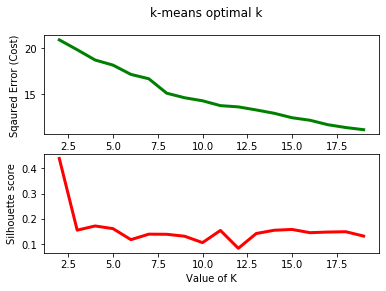

In [324]:
fig, axs = plt.subplots(2)
fig.suptitle('k-means optimal k')
axs[0].plot(range(2, 20), cost, color ='g', linewidth ='3')
axs[0].set_xlabel("Value of K") 
axs[0].set_ylabel("Sqaured Error (Cost)")
axs[1].plot(range(2, 20), score, color='r', linewidth = '3')
axs[1].set_xlabel("Value of K") 
axs[1].set_ylabel("Silhouette score")

In [350]:
df_DC_neigh2['Cluster Labels'] = kmeans.labels_
df_DC_neigh2.head()

,Neighborhood,Total Venues,E-scores,Latitude,Longitude,TotalCrimes,ViolentCrimes,PropertyCrimes,Cluster Labels
0,16th Street Heights,14,2.567629,38.950315,-77.033559,78,4,74,0
1,Adams Morgan,57,4.025507,38.920472,-77.042391,473,39,434,0
2,American University Park,2,0.193147,38.947612,-77.090250,35,4,31,0
3,Arboretum,15,2.641384,38.914860,-76.972490,86,13,73,0
4,Barnaby Woods,4,1.136294,38.975433,-77.060174,36,0,36,0


In [354]:
df_DC_neigh3=df_DC_neigh2.reindex(columns= ['Neighborhood', 'Latitude','Longitude','Total Venues','E-scores','Cluster Labels','TotalCrimes','ViolentCrimes','PropertyCrimes'])
df_DC_neigh3.head(20)



,Neighborhood,Latitude,Longitude,Total Venues,E-scores,Cluster Labels,TotalCrimes,ViolentCrimes,PropertyCrimes
0,16th Street Heights,38.950315,-77.033559,14,2.567629,0,78,4,74
1,Adams Morgan,38.920472,-77.042391,57,4.025507,0,473,39,434
2,American University Park,38.947612,-77.090250,2,0.193147,0,35,4,31
3,Arboretum,38.914860,-76.972490,15,2.641384,0,86,13,73
4,Barnaby Woods,38.975433,-77.060174,4,1.136294,0,36,0,36
5,Barry Farm,38.859255,-76.997281,6,1.625093,0,119,40,79
6,Bellevue,38.826952,-77.009271,5,1.409438,0,151,45,106
7,Benning,38.891885,-76.948884,17,2.774390,0,307,55,252
8,Benning Ridge,38.881161,-76.938203,3,0.765279,6,110,32,78
9,Bloomingdale,38.918226,-77.011159,18,2.834816,0,321,40,281


# Plot DC Neighborhood Clusters

In [352]:
# create map
map_clusters = folium.Map(location=[DClatitude, DClongitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_DC_neigh3['Latitude'], df_DC_neigh3['Longitude'], df_DC_neigh3['Neighborhood'], df_DC_neigh3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Explore data relationships to predict DC neighborhood crime totals from venue features (Total Venues and Entropy score (E-score))

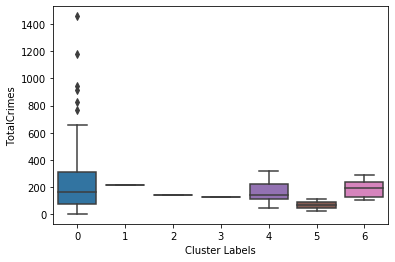

In [353]:
sns.boxplot(x="Cluster Labels", y="TotalCrimes", data=df_DC_neigh3)

In [366]:
df_DC_neigh_clustergrouped = df_DC_neigh3.groupby('Cluster Labels').mean().reset_index()
df_DC_neigh_clustergrouped1 = df_DC_neigh_clustergrouped[['Cluster Labels','TotalCrimes','ViolentCrimes','PropertyCrimes']]
df_DC_neigh_clustergrouped1.head()

,Cluster Labels,TotalCrimes,ViolentCrimes,PropertyCrimes
0,0,237.54955,28.981982,208.567568
1,1,215.00000,59.000000,156.000000
2,2,139.00000,39.000000,100.000000
3,3,126.00000,7.000000,119.000000
4,4,168.25000,27.125000,141.125000


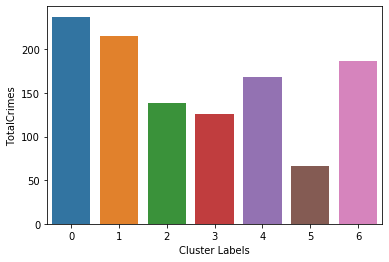

In [367]:
%matplotlib inline 
import seaborn as sns
ax = sns.barplot(x="Cluster Labels", y="TotalCrimes", data=df_DC_neigh_clustergrouped1)

(0, 1531.9166942604857)

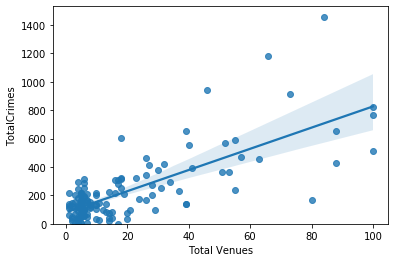

In [355]:
%matplotlib inline 
import seaborn as sns
sns.regplot(x="Total Venues", y="TotalCrimes", data=df_DC_neigh3)
plt.ylim(0,)

(0, 1543.1237565773922)

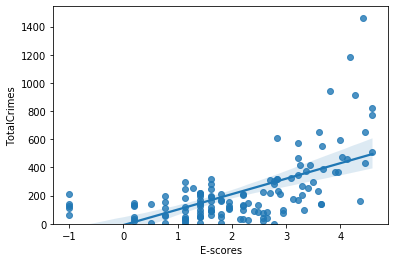

In [356]:
sns.regplot(x="E-scores", y="TotalCrimes", data=df_DC_neigh3)
plt.ylim(0,)

In [357]:
def PlotPolly(model, independent_variable, dependent_variable, Name):
    x_new = np.linspace(-1, 5, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variable, '.', x_new, y_new, '-')
    plt.title('DC Crime Totals 2019 vs. Neighborhood Venue Entropy')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Number of Crimes 2019')

    plt.show()
    plt.close()

In [358]:
x = df_DC_neigh3['E-scores']
y = df_DC_neigh3['TotalCrimes']

f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)

       3         2
10.28 x - 12.25 x - 14.64 x + 126.4


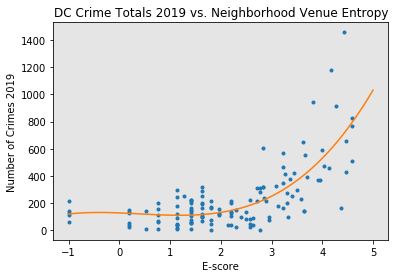

In [332]:
PlotPolly(p, x, y, 'E-score')

# Use polynomial and multi-variate polynomial regression to predict for Total Crimes with features = 'Total Venues' and 'E-scores'

In [361]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
Z = df_DC_neigh3[['Total Venues', 'E-scores']]
Z1 = df_DC_neigh3[['E-scores']]
pr1 = PolynomialFeatures(degree=3)
Z_pr = pr1.fit_transform(Z)
Z1_pr = pr1.fit_transform(Z1)
Input = [('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model',LinearRegression())]
pipe = Pipeline(Input)
pipe.fit(Z,y)
ypipe = pipe.predict(Z)
pipe.fit(Z1,y)
ypipe1 = pipe.predict(Z1)

In [362]:
df_DC_neigh4 = df_DC_neigh3
df_DC_neigh4['MVPolyFit_TotalCrimes'] = ypipe
df_DC_neigh4['PolyFit_TotalCrimes'] = ypipe1
df_DC_neigh4.head(20)

,Neighborhood,Latitude,Longitude,Total Venues,E-scores,Cluster Labels,TotalCrimes,ViolentCrimes,PropertyCrimes,MVPolyFit_TotalCrimes,PolyFit_TotalCrimes
0,16th Street Heights,38.950315,-77.033559,14,2.567629,0,78,4,74,157.213696,212.409184
1,Adams Morgan,38.920472,-77.042391,57,4.025507,0,473,39,434,590.718998,531.815090
2,American University Park,38.947612,-77.090250,2,0.193147,0,35,4,31,127.244632,84.546966
3,Arboretum,38.914860,-76.972490,15,2.641384,0,86,13,73,165.740429,224.166419
4,Barnaby Woods,38.975433,-77.060174,4,1.136294,0,36,0,36,119.520865,77.127420
5,Barry Farm,38.859255,-76.997281,6,1.625093,0,119,40,79,116.372357,103.461353
6,Bellevue,38.826952,-77.009271,5,1.409438,0,151,45,106,116.973949,89.303169
7,Benning,38.891885,-76.948884,17,2.774390,0,307,55,252,184.064418,246.554674
8,Benning Ridge,38.881161,-76.938203,3,0.765279,6,110,32,78,123.813010,70.893626
9,Bloomingdale,38.918226,-77.011159,18,2.834816,0,321,40,281,193.749880,257.229908


In [ ]:
ys